# Tutorial on learned Cardinality Estimation in Knowledge Graphs

## Introduction

In this tutorial, you learn how to use Graph Neural Networks and Knowledge Graph Embeddings to predict the cardinality of conjunctive SPARQL queries. This approach is presented in 
the research paper [Cardinality Estimation over Knowledge Graphs with Embeddings and Graph Neural Networks](https://dl.acm.org/doi/10.1145/3639299). The approach is named **GNCE**.

We will work through the following points:
1. Dataset Exploration
2. KG Embedding Generation and Analysis
3. Cardinality Estimator Training
4. Analysis of the results
5. Exercise: Investigate how Embedding Dimension and Number of Training Queries influence Estimator Performance

## Cardinality Estimation

In **cardinality estimation**, the goal is to learn a function that approximates the mapping from queries to their result cardinalities (number of results for the query).  

Formally, given a query $q$, we seek a function $f$ such that  


$f(q) \approx\; |q|$

where $|q|$ denotes the true number of results returned by the query.


In **GNCE**, we represent $f$ using a graph neural network (GNN) and train it via supervised learning with a mean squared error (MSE) loss.  

Formally, given a training set of queries $\{q_i\}_{i=1}^N$ with true cardinalities $\{|q_i|\}_{i=1}^N$, we optimize  


$\mathcal{L} \;=\; \frac{1}{N} \sum_{i=1}^N \big( f(q_i) - |q_i| \big)^2$



Since we employ a GNN, each query is represented as a graph.  
- **Nodes** correspond to the subjects and objects in the query’s triple patterns.  
- **Edges** correspond to the predicates connecting them.  

To obtain meaningful representations, we assign **knowledge graph embeddings (KGE)** as feature vectors to both nodes and edges.


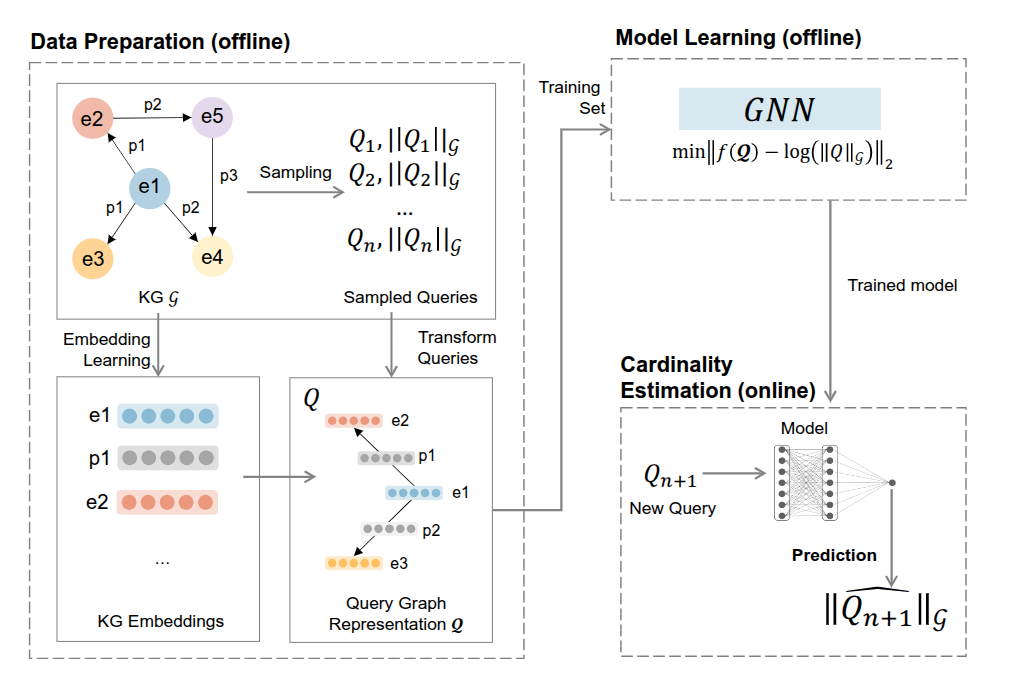

In [ ]:
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.graphs import KG
from pyrdf2vec.walkers import RandomWalker
from pyrdf2vec.embedders import Word2Vec
import json
import os
import pickle
import numpy as np
from tqdm import tqdm
from cardinality_estimation import train_GNCE


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



## Data Exploration

As our Knowledge Graph today, we use Semantic Web Dog Food (SWDF), a scholarly KG with papers, authors, citations etc. In total, the graph has 242256 triples, 76711 entities and 170 distinct predicates. 28% of the entities are typed,
with a total of 118 different classes.

For SPARQL queries over this graph, we are looking at **Star-shaped Queries.** I.e. queries with a central node and only outgoing edges from this node.

Lets load the queries and have a look at them:

In [ ]:
with open('Datasets/swdf/star/Joined_Queries.json', 'r') as f:
   queries = json.load(f)

In [ ]:
queries[0]

Each query here is a dict that holds the raw SPARQL query, the triples of the query, the entities and predicates occurring in the query and the true cardinality (y).

In [ ]:
len(queries)

In total, we do have ~116k queries.

In [ ]:
plt.hist([len(q['triples']) for q in queries])
plt.show()

We have queries with either 2,3,5 or 8 triple pattern, with a very balanced distribution.

## Embedding Learning


As the first step, we need to learn the embeddings for our entities. While there are many different KGE algorithms, we will use **RDF2Vec**. It encodes similarity and relatedness between entities, and a query consisiting of related 
entities should have a higher cardinality.
We will also calculate the **occurrence** for each entity and predicate, i.e. in how many triples it occurrs. This quantity is very cheap to obtain and serves as an upper bound for the cardinality ( as the upper bound is given by the cartesian product)

Lets first compute all the entities occurring in our queries, as we only need embeddings for those:

In [ ]:
entities = []

for query in queries:
   entities += query['x']

entities = list(set(entities))
entities = entities[:]

print('Using ', len(entities), ' entities for RDF2Vec')

Now we can start the learning procedure using pyrdf2vec. The approach first samples random walks from the swdf KG, and then learns embeddings using them. We will combine the embeddings with the occurrences into a single dict that we can later pass to the cardinality estimator learning pipeline

In [ ]:
# We first define a KG object for pyrdf2vec
graph_file="Datasets/swdf/graph/swdf.nt"
kg = KG(graph_file, skip_verify=True)

# Next, we define the strategy with which we generate the random walks
walker = RandomWalker(max_depth=4, max_walks=10, with_reverse=False, n_jobs=24)

# And then define the word2vec model
embedder = Word2Vec(epochs=10, vector_size=100)

# Finally the full pipeline
model = RDF2VecTransformer(
    walkers=[walker],
    embedder=embedder,
    verbose=1,
)

# Now, we start the embedding learning, which will internally generate walks, learn embeddings and return them to us for the chosen entities
result = model.fit_transform(kg, entities)


# Extract embeddings from the tuple (embeddings, literals)
embeddings, literals = result

# Create entity-embedding mapping
embeddings_dict = {}
for i, entity in enumerate(entities):
    if i < len(embeddings):
        embeddings_dict[entity] = embeddings[i]
    else:
        embeddings_dict[entity] = []


# Calculate occurrences
print("Calculating occurrences...")
occurrences = {}
with open(graph_file, "r") as file:
    for line in tqdm(file):
        line = line.strip().split(" ")
        s = line[0].replace("<", "").replace(">", "")
        p = line[1].replace("<", "").replace(">", "")
        o = line[2].replace("<", "").replace(">", "")
        
        occurrences[s] = occurrences.get(s, 0) + 1
        occurrences[p] = occurrences.get(p, 0) + 1
        occurrences[o] = occurrences.get(o, 0) + 1

# Convert to JSON format with embeddings and occurrences
embeddings_dict_json = {}
for entity, embedding in embeddings_dict.items():
    embedding_list = embedding.tolist() if embedding is not None and hasattr(embedding, 'tolist') else embedding
    occurrence_count = occurrences.get(entity, 0)
    embeddings_dict_json[entity] = {"embedding": embedding_list, "occurence": occurrence_count}

with open("Datasets/swdf/swdf_embeddings.json", "w") as f:
    json.dump(embeddings_dict_json, f, indent=2)


All embeddings have been learned, lets look at an example entry:

In [ ]:
embeddings_dict_json['http://ex.org/25074']

The embeddings is a array with small floats around 0. The occurrence is 10 meaning this entity occurrs in 10 different triples in the KG

Lets further investigate the embeddings by projecting them to 2 dimensions and plotting them:

In [ ]:
# Convert lists back to numpy arrays
embeddings_dict = {}
for entity, data in embeddings_dict_json.items():
    if data is not None and isinstance(data, dict) and "embedding" in data:
        embedding = data["embedding"]
        if embedding is not None and isinstance(embedding, list) and len(embedding) > 0:
            embeddings_dict[entity] = np.array(embedding)
        else:
            embeddings_dict[entity] = embedding
    else:
        embeddings_dict[entity] = data


# Filter out any None or invalid embeddings
valid_entities = []
valid_embeddings = []

for entity, embedding in embeddings_dict.items():
    if embedding is not None and hasattr(embedding, 'shape') and embedding.shape[0] > 0:
        valid_entities.append(entity)
        valid_embeddings.append(embedding)

if not valid_embeddings:
    print("No valid embeddings found!")
    exit()

entity_names = valid_entities
embedding_matrix = np.vstack(valid_embeddings)

print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Explanation: We have {embedding_matrix.shape[0]} entities, each represented by {embedding_matrix.shape[1]}-dimensional embeddings")

# Visualize embeddings in 2D using dimensionality reduction
# Method 1: PCA (Principal Component Analysis)
print("\nApplying PCA for dimensionality reduction...")
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embedding_matrix)

# Method 2: t-SNE (t-Distributed Stochastic Neighbor Embedding)
print("Applying t-SNE for dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(entity_names)-1))
embeddings_tsne = tsne.fit_transform(embedding_matrix)

# Create visualization for embeddings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot PCA results
ax1.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], alpha=0.7, s=100)

ax1.set_title('PCA Visualization of RDF2Vec Embeddings')
ax1.grid(True, alpha=0.3)

# Plot t-SNE results  
ax2.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.7, s=100)
ax2.set_title('t-SNE Visualization of RDF2Vec Embeddings')
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('embeddings_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved as 'embeddings_visualization.png'")

While the PCA embeddings are not very informative, the t-sne reveals that we have a few different clusters that are even preserved after dimensionality reduction. So the embeddings appear to have learned some structure of our graph

## Cardinality Estimator GNN Training

Now that we have the embeddings and occurrences in place, we can start training our GNN. The figure below shows the GNN architecture used in GNCE:

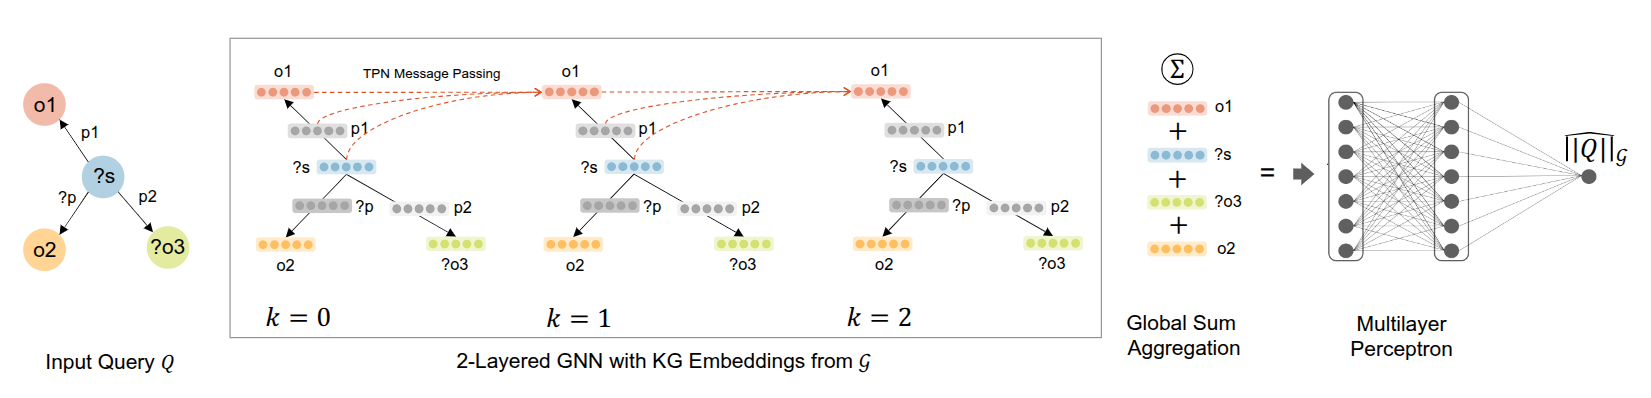

The graph of the initial query is first transformed by attaching the learned KGE to the nodes and edges $(k=0)$. This graph is then processed by 2 **message-passing layers** $(k=1,2)$. These pass and transform information between the nodes, so that the representation vectors of the nodes encode the local neighborhood and structure.


Then, the final representation of all nodes are aggregated using summation, which results in a single vector. Lastly, this vector is transformed by a 2-layer MLP into a single scalar, which represents the predicted cardinality of the query.

Lets start by defining some flags for the training:

In [ ]:
starttime = 'TEST' # Folder Name
query_filename = "Joined_Queries.json" # Name of the query file
dataset = 'swdf' # Dataset Name
query_type = 'star' # type of queries we look at
DATASET_PATH = 'Datasets/' # where the dataset and queries are stored

N_TRAIN_QUERIES = 100 # on how many queries to train
N_TEST_QUERIES = 1000 # on how many queries to test
EPOCHS = 5 # how many times we loop over the queries during training

# Whether to perform full inductive training
inductive = 'false' # Choices are 'false' or 'full'. false means normal training and full means evaluating without embeddings


We use the `train_GNCE` function that is provided by this repository. Internally, it loads the queries from the provided file, loads the embeddings and transforms the queries to graphs with embeddings as features.
It then train the Cardinality Estimation GNN on the first `N_TRAIN_QUERIES`and evaluates on the last `N_TEST_QUERIES`. 

Lets train it.

In [ ]:
n_atoms, start_time_gnce,  end_time_gnce, preds, gts, sizes = train_GNCE(dataset=dataset, query_type=query_type, query_filename=query_filename, eval_folder=starttime,
           inductive=inductive, DATASETPATH=DATASET_PATH, n_train_queries=N_TRAIN_QUERIES, n_test_queries=N_TEST_QUERIES, epochs=EPOCHS)


Great, the training is finished. During Training, we already saw some metrics being printed out. The function returns multiple things, but important to us are preds, gts and sizes.
preds is an array of cardinality predictions for the test queries, gts are the true cardinalities for the queries, and sizes contains the sizes (number of triple patterns) of the respective queries.

## Analysis of the Cardinality Estimator Training

Lets now investigate how well the training went. Lets first look at the raw predictions compared to the true cardinalities in a scatter plot:

In [ ]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(gts, preds, c=sizes, alpha=0.7, s=50, cmap='viridis')

# Add colorbar to show size mapping
cbar = plt.colorbar(scatter)
cbar.set_label('Query Size', rotation=270, labelpad=20)

# Add perfect prediction line (y=x)
min_val = min(min(gts), min(preds))
max_val = max(max(gts), max(preds))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction (y=x)')

plt.xlabel('True Cardinality')
plt.ylabel('Predicted Cardinality')
plt.legend()
plt.grid(True, alpha=0.3)

if max_val / min_val > 100:
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()

**Exercise 1: Interpret the results**

..............

Lets now try to quantify how well the training worked. There are several suitable metrics to compare predicted real numbers to the target value. In cardinality estimation, the so called Q-Error is most often used. It is defined as

$\mathcal{L}(true, pred) = max(\frac{true}{pred}, \frac{pred}{true})$

I.e. a perfect prediction would yield a q-error of 1. The q-Error is commonly used in cardinality estimation, because it is **scale-invariant**. E.g. if you predict $10^9$ instead of $10^8$, the q-error is 10, the same as if you predicted 100 instead of 10. This makes sure that the same relative errors in smaller cardinality regimes are weighted the same as equivalent errors for larger cardinalities.

Further, an error of 100 is much worse if the true cardinality is 200 than if it would have been e.g. $10^8$.

Lets calculate the mean q-Error for our predictions:

In [ ]:
preds = np.array(preds)
gts = np.array(gts)

# Filter out cases where ground truth (they shouldnt be in the dataset, but we make sure) is 0 to avoid division by zero
valid_mask = gts > 0
valid_preds = preds[valid_mask]
valid_gts = gts[valid_mask]

q_errors = np.maximum(valid_preds / valid_gts, valid_gts / valid_preds)
mean_q_error = np.mean(q_errors)
median_q_error = np.median(q_errors)

print(f"Q-error statistics:")
print(f"  Mean Q-error: {mean_q_error:.4f}")
print(f"  Median Q-error: {median_q_error:.4f}")
print(f"  Min Q-error: {np.min(q_errors):.4f}")
print(f"  Max Q-error: {np.max(q_errors):.4f}")

**Exercise 2: Interpret the results !**

..............

Great ! Lastly, we would like to know how the q-Error behaves for different query-sizes to have a more nuanced understanding.

In [ ]:
# We first need to calculate the different sizes appearing
unique_sizes = np.unique(sizes)

mean_q_errors_per_size = []
query_counts_per_size = []

for size in unique_sizes:
    # Get indices where the size matches and ground truth > 0
    size_mask = (sizes == size) & (gts > 0)
    size_indices = np.where(size_mask)[0]
    
    # Get corresponding q-errors (need to map back to the filtered q_errors array)
    valid_indices = np.where(valid_mask)[0]
    q_error_indices = np.isin(valid_indices, size_indices)
    
    if np.any(q_error_indices):
        size_q_errors = q_errors[q_error_indices]
        mean_q_errors_per_size.append(np.mean(size_q_errors))
        query_counts_per_size.append(len(size_q_errors))
    else:
        mean_q_errors_per_size.append(0)
        query_counts_per_size.append(0)

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(unique_sizes, mean_q_errors_per_size, alpha=0.7, color='skyblue', edgecolor='navy')

plt.xlabel('Query Size')
plt.ylabel('Mean Q-error')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
               

**Exercise 3: Interpret the results**

............

**Exercise 4: Investigate the behavior of different training parameters**

Now, after having gone through the embedding generation and the training and evaluation of the cardinality estimator, your task is to investigate how different aspects of the training influence the validation q-error. For that,
investigate how the following three hyperparameters influence the training:
1. Number of Training Queries (e.g. 100, 1000,10000)
2. Number of Training Epochs (e.g. 1 to 10)

The goal is to produce a plot with the hyperparameter on the x-axis and the mean q-error on the y-axis.